In [38]:
!pip install transformers sentence-transformers bertopic safetensors > /dev/null

## K-Means Clustering

 K-Means requires that the number of clusters is specified beforehand.

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

In [ ]:
embed_minilm = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
data_corp = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'A man is eating pasta.',
          'The girl is carrying a baby.',
          'The baby is carried by the woman',
          'A man is riding a horse.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'Someone in a gorilla costume is playing a set of drums.',
          'A cheetah is running behind its prey.',
          'A cheetah chases prey on across a field.'
          ]

In [ ]:
data_embed = embed_minilm.encode(data_corp)

In [ ]:
#starting the clustering process

num_cluster = 5

kmeans_model = KMeans(n_clusters=num_cluster)

In [ ]:
kmeans_model.fit(data_embed)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [ ]:
clusters = kmeans_model.labels_

In [ ]:
clusters

array([0, 0, 0, 1, 1, 3, 3, 4, 4, 2, 2], dtype=int32)

In [ ]:
import pandas as pd

def make_df(cluster_list, text_list):
  clustered_dataset = []
  for ind, cluster in enumerate(cluster_list):
    cluster_dict = {'cluster':cluster,
                    'sentence':text_list[ind]}
    clustered_dataset.append(cluster_dict)

  cluster_dict = pd.DataFrame(clustered_dataset)

  return cluster_dict

In [ ]:
clustered_dataset = []
for ind, cluster in enumerate(clusters):
  cluster_dict = {'cluster':cluster,
                  'sentence':data_corp[ind]}
  clustered_dataset.append(cluster_dict)

In [ ]:
import pandas as pd

cluster_dict = pd.DataFrame(clustered_dataset)

cluster_dict

,cluster,sentence
0,0,A man is eating food.
1,0,A man is eating a piece of bread.
2,0,A man is eating pasta.
3,1,The girl is carrying a baby.
4,1,The baby is carried by the woman
5,3,A man is riding a horse.
6,3,A man is riding a white horse on an enclosed g...
7,4,A monkey is playing drums.
8,4,Someone in a gorilla costume is playing a set ...
9,2,A cheetah is running behind its prey.


## Agglomerative Clustering

 Clusters below that threshold are merged. This algorithm can be useful if the number of clusters is unknown.

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [ ]:
np.linalg.norm(data_embed, axis=1, keepdims=True)

array([[0.99999994],
       [0.99999994],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.9999999 ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.99999994]], dtype=float32)

In [ ]:
normalized_embed = data_embed / np.linalg.norm(data_embed, axis=1, keepdims=True)

In [ ]:
agglomerate_model = AgglomerativeClustering(n_clusters=None,
                                            distance_threshold = 1.5)

In [ ]:
agglomerate_model.fit(normalized_embed)

AgglomerativeClustering(distance_threshold=1.5, n_clusters=None)

In [ ]:
agglo_clusters = agglomerate_model.labels_

In [ ]:
agglo_clusters

array([0, 0, 0, 4, 4, 1, 1, 2, 2, 3, 3])

In [ ]:
agglo_df = make_df(agglo_clusters,data_corp)
#agglo_df

,cluster,sentence
0,0,A man is eating food.
1,0,A man is eating a piece of bread.
2,0,A man is eating pasta.
3,4,The girl is carrying a baby.
4,4,The baby is carried by the woman
5,1,A man is riding a horse.
6,1,A man is riding a white horse on an enclosed g...
7,2,A monkey is playing drums.
8,2,Someone in a gorilla costume is playing a set ...
9,3,A cheetah is running behind its prey.


## Fast Clustering for Massive Dataset

In [ ]:
url = "http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv"
dataset_path = "quora_duplicate_questions.tsv"
max_corpus_size = 50000  # We limit our corpus to only the first 50k questions

In [ ]:
from sentence_transformers import util
import os

if not os.path.exists(dataset_path):
    print("Download dataset")
    util.http_get(url, dataset_path)

In [ ]:
import csv

# Get all unique sentences from the file upto max_corpus_size

corpus_sentences = set()

with open(dataset_path, encoding='utf8') as fIn:

    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_MINIMAL)
    for row in reader:
        corpus_sentences.add(row['question1'])
        corpus_sentences.add(row['question2'])
        if len(corpus_sentences) >= max_corpus_size:
            break

In [ ]:
corpus_sentences = list(corpus_sentences)

In [ ]:
quora_embed = embed_minilm.encode(corpus_sentences,
                                  batch_size=64,
                                  show_progress_bar=True,
                                  convert_to_tensor=True)

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
import time

start = time.time()

clusters_community = util.community_detection(quora_embed,
                                              min_community_size=25,
                                              threshold=0.75)

complete = time.time()

print(f"Clustering completed in {complete - start} time")

Clustering completed in 51.11092782020569 time


In [ ]:
print(f"There are {len(clusters_community)} clusters")

There are 61 clusters


In [ ]:
quora_clustered = []

for ind, sentences in enumerate(clusters_community):
  for sentence in sentences:
    quora_dict = {"cluster":ind,
                  "sentence_id":sentence,
                  "sentence":corpus_sentences[sentence]}
    quora_clustered.append(quora_dict)

clustered_df = pd.DataFrame(quora_clustered)

In [ ]:
clustered_df

,cluster,sentence_id,sentence
0,0,859,How can I improve my English speaking ability?
1,0,1010,How can I learn to speak English fluently?
2,0,1115,How do I improve my overall native English lan...
3,0,1232,How can I learn to speak English?
4,0,2192,How can I improve my english language skills? ...
...,...,...,...
2279,60,45292,What is the step by step guide to invest in sh...
2280,60,45399,How do I earn money from the stock market?
2281,60,47162,What all does somebody need to know to start i...
2282,60,47419,How do I make a profit in the stock market?


In [52]:
from sklearn.datasets import fetch_20newsgroups
docs = fetch_20newsgroups(subset='all',  remove=('headers',
                                                 'footers',
                                                 'quotes'))['data']

In [53]:
len(docs)

18846

In [ ]:
docs[5:50]

In [ ]:
docs_embed = embed_minilm.encode(docs[:5000],batch_size=64,
                                  show_progress_bar=True)

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
import pickle

with open('docs_embeddings.pkl','wb') as fout:
  pickle.dump({'sentences':docs[:5000],
               'embeddings':docs_embed},
              fout,
              protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
import pickle

with open('/content/docs_embeddings.pkl','rb') as fin:
  docs_embed = pickle.load(file=fin,fix_imports=True)

In [ ]:
docs_embed

In [44]:
from bertopic import BERTopic

topic_model = BERTopic(language="english",
                       calculate_probabilities=True,
                       verbose=True)
topics, probs = topic_model.fit_transform(embeddings=docs_embed['embeddings'],
                                          documents=docs[:5000])

2023-06-16 03:16:36,874 - BERTopic - Reduced dimensionality
2023-06-16 03:16:38,537 - BERTopic - Clustered reduced embeddings


In [ ]:
#Access the frequent topics that were generated:

topic_model.get_topic_info()

In [ ]:
topic_model.get_topic(0)

[('game', 0.013907644172698382),
 ('team', 0.012423780162947083),
 ('he', 0.012285414370801205),
 ('the', 0.011055874442977419),
 ('10', 0.01015492838806086),
 ('in', 0.010034090870948023),
 ('players', 0.009659262746097172),
 ('to', 0.009234142973611758),
 ('was', 0.009087920638540196),
 ('and', 0.008554304237091576)]

In [ ]:
topic_model.get_document_info(docs[:5000])

In [ ]:
topic_list = topic_model.generate_topic_labels()

In [ ]:
topic_model.reduce_topics(docs[:5000],nr_topics=30)

2023-06-16 01:31:20,805 - BERTopic - Reduced number of topics from 68 to 30


In [ ]:
topic_reduced = topic_model.generate_topic_labels()
topic_reduced

In [ ]:
topic_model.find_topics("windows")

In [ ]:
topic_model.save("topic_model",serialization='safetensors')

In [ ]:
from huggingface_hub import login
login()

In [ ]:
embed_model = 'sentence-transformers/all-MiniLM-L6-v2'

In [ ]:
topic_model.push_to_hf_hub(
    repo_id='Kamaljp/topic_docs5000',
    save_ctfidf=True,
    save_embedding_model=embed_model,
    serialization='pytorch'
)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

topic_embeddings.bin:   0%|          | 0.00/46.9k [00:00<?, ?B/s]

ctfidf.bin:   0%|          | 0.00/2.16M [00:00<?, ?B/s]

'https://huggingface.co/Kamaljp/topic_docs5000/tree/main/'

In [ ]:
topics_ = topic_model.topics_

In [ ]:
topic_sizes = topic_model.topic_sizes_

In [ ]:
topic_sizes

Counter({0: 450,
         1: 344,
         3: 220,
         -1: 1606,
         6: 172,
         14: 100,
         9: 169,
         2: 246,
         13: 100,
         5: 186,
         10: 146,
         17: 56,
         4: 203,
         23: 21,
         20: 28,
         25: 16,
         15: 94,
         11: 132,
         8: 169,
         12: 105,
         21: 27,
         7: 172,
         27: 13,
         18: 45,
         24: 17,
         19: 44,
         16: 66,
         26: 15,
         22: 26,
         28: 12})

In [ ]:
topic_reps = topic_model.topic_representations_
topic_reps

In [ ]:
topic_ctfidf = topic_model.c_tf_idf_
topic_ctfidf

<30x62308 sparse matrix of type '<class 'numpy.float64'>'
	with 137936 stored elements in Compressed Sparse Row format>

In [ ]:
topic_embedding = topic_model.topic_embeddings_
topic_embedding

In [45]:
topic_distr, _ = topic_model.approximate_distribution(docs[:5000])

100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


In [46]:
topic_model.visualize_distribution(topic_distr[1])

In [47]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)

# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(docs[1], topic_token_distr[1])
df

100%|██████████| 19/19 [01:18<00:00,  4.11s/it]


,My,brother,is,in,the,market,for,high,performance,video,card,that,supports,VESA,local,bus,with,2MB,RAM,Does,anyone,have,suggestions,ideas,on,Diamond,Stealth,Pro,Local,Bus,Orchid,Farenheit,1280,ATI,Graphics,Ultra,Pro,Any,other,high,performance,VLB,card,Please,post,or,email,Thank,you,Matt
5_card_monitor_video_drivers,0.000,0.000,0.000,0.000,0.000,0.000,0.161,0.433,0.733,1.012,1.015,0.743,0.443,0.164,0.000,0.000,0.000,0.000,0.123,0.225,0.225,0.225,0.102,0.000,0.000,0.105,0.105,0.105,0.105,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.107,0.322,0.549,0.773,0.901,0.685,0.459,0.234,0.000,0.000,0.000,0.000
9_mhz_cpu_speed_motherboard,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.114,0.114,0.114,0.114,0.000,0.000,0.000,0.000,0.000,0.000,0.115,0.115,0.115,0.115,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
10_jim_you_context_your,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.114,0.242,0.345,0.345,0.230,0.103,0.000,0.000
16_windows_memory_problem_running,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.128,0.128,0.128,0.128,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
18_address_mail_me_email,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.108,0.293,0.459,0.627,0.632,0.447,0.281,0.113
28_shipping_bid_sell_cdtv,0.000,0.000,0.000,0.000,0.000,0.000,0.102,0.102,0.102,0.102,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
44_os_mac_ibm_32,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.111,0.111,0.111,0.111,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
56_simms_jh_memory_70ns,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.110,0.110,0.110,0.110,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
67_isa_bus_eisa_ide,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.219,0.470,0.691,0.887,0.668,0.417,0.196,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.190,0.374,0.523,0.645,0.455,0.271,0.122,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
70_anyone_itll_dean_place,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.108,0.108,0.108,0.108,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.128,0.128,0.128,0.128,0.000,0.000,0.000


## Online Topic Modeling

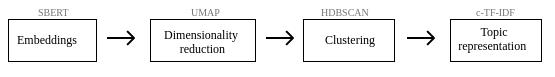

In [59]:
doc_chunks = [docs[5000:i+1000] for i in range(5000, len(docs), 1000)]

In [ ]:
doc_chunks[2]

In [49]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA
from bertopic.vectorizers import OnlineCountVectorizer

# Prepare sub-models that support online learning
umap_model = IncrementalPCA(n_components=5)
cluster_model = MiniBatchKMeans(n_clusters=50, random_state=0)
vectorizer_model = OnlineCountVectorizer(stop_words="english", decay=.01)

In [ ]:
from bertopic import BERTopic

topic_model_ol = BERTopic(umap_model=umap_model,
                       hdbscan_model=cluster_model,
                       vectorizer_model=vectorizer_model)

# Incrementally fit the topic model by training on 1000 documents at a time
for docs in doc_chunks:
    topic_model_ol.partial_fit(docs)

## Semi Supervised

In [62]:
data = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))

docs = data["data"]
categories = data["target"]
category_names = data["target_names"]

In [ ]:
#Initiating the topic modeling with categories
topic_model_ss = BERTopic(verbose=True).fit(docs[:100], y=category_names)